# Set-up

In [1]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px
import seaborn as sns
import numpy as np
import random

sns.set_theme()
colors = sns.color_palette("deep")
seq_colors = sns.color_palette("rocket")

from math import floor, ceil, sqrt
from NMF_iter import functional_norm, normalize_curves
from scipy.stats import levene

from itertools import permutations

In [18]:
def plot_components(H_dict, nrows=None, ncols=None, figsize=(20, 10), ylim=None):
    if nrows is None and ncols is None:
        nrows = floor(sqrt(len(H_dict)))
        ncols = ceil(len(H_dict) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=True)

    for idx, (method, H) in enumerate(H_dict.items()):
        i = idx // ncols
        j = idx % ncols
        
        abscissa = np.linspace(0, 24, H.shape[1])
        for k in range(H.shape[0]):
            label = f'Component {k + 1}'
            if 'smoothed' in method:
                marker=None
            else:
                marker = 'o'
            axs[i,j].plot(abscissa, H[k, :], marker=marker, linestyle='-', label=label)
        
        axs[i,j].set_xlabel('Hour')
        # axs[i,j].set_ylabel('Normalized Load')
        axs[i,j].set_title(method)
        axs[i,j].legend()
        if ylim:
            ylim = axs[i,j].set_ylim(ylim)
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [4]:
def plot_residual_curves(residuals_dict, n_curves_plotted=10, nrows=None, ncols=None, figsize=(20, 10), **kwargs):
    if nrows is None and ncols is None:
        nrows = floor(sqrt(len(residuals_dict)))
        ncols = ceil(len(residuals_dict) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=True)

    curves_to_plot = random.sample(range(next(iter(residuals_dict.values())).shape[0]), n_curves_plotted)

    for idx, (method, resid) in enumerate(residuals_dict.items()):
        i = idx // ncols
        j = idx % ncols
        
        for n in curves_to_plot:
            axs[i,j].plot(resid.iloc[n, :], marker='o', linestyle='-', **kwargs)
        
        axs[i,j].set_xlabel('Hour')
        # axs[i,j].set_ylabel('Normalized Load')
        axs[i,j].set_title(method)
        # axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [5]:
def plot_residual_boxplots(residuals_with_info, nrows=None, ncols=None, figsize=(20, 10), rotate_xlabels=False, **kwargs):
    nrows = floor(sqrt(len(residuals_with_info)))
    ncols = ceil(len(residuals_with_info) / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharex=True, sharey=True)

    for idx, (method, resid_df)  in enumerate(residuals_with_info.items()):
        i = idx // ncols
        j = idx % ncols
        sns.boxplot(
            resid_df,
            y='residual',
            ax=axs[i, j],
            **kwargs
        )
        axs[i, j].set_title(method)
        if rotate_xlabels:
            axs[i, j].tick_params(axis='x', rotation=45)
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [6]:
def plot_random_reconstructed(reconstructed, X, n_obs=4, override_methods=None, figsize=(20,10), **kwargs):
    nrows = floor(sqrt(n_obs))
    ncols = ceil(n_obs / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharex=True, sharey=True)
    
    first_element = next(iter(reconstructed.values()))
    random_curves_idx = random.sample(first_element.index.to_list(), n_obs)

    for idx, name in enumerate(random_curves_idx):
        i = idx // ncols
        j = idx % ncols
        for method, recons in reconstructed.items():
            if override_methods:
                if method in override_methods:
                    axs[i,j].plot(recons.loc[name], marker='o', linestyle='-', label=method, **kwargs)
            else:
                axs[i,j].plot(recons.loc[name], marker='o', linestyle='-', label=method, **kwargs)
        axs[i,j].plot(X.loc[name], marker='o', linestyle='-', label='True curve', **kwargs)
        axs[i,j].set_xlabel('Hour')
        axs[i,j].set_title(name)
        axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [7]:
info_cols = ['region', 'year', 'month', 'daytype']

def plot_concentrations_boxplots(
        W_with_info,
        nrows=None,
        ncols=None,
        figsize=(20, 10),
        rotate_xlabels=False,
        title=None,
        replicate_legend=True,
        subplots_titles=None,
        legend_position=None,
        ncols_legend=None,
        **kwargs
    ):
    nrows = floor(sqrt(len(W_with_info)))
    ncols = ceil(len(W_with_info) / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharex=True, sharey=True)

    for idx, (method, W_df)  in enumerate(W_with_info.items()):
        i = idx // ncols
        j = idx % ncols
        sns.boxplot(
            W_df.melt(id_vars=info_cols, var_name='component', value_name='concentration'),
            y='concentration',
            ax=axs[i, j],
            **kwargs
        )
        if subplots_titles:
            axs[i, j].set_title(subplots_titles[idx])
        else:
            axs[i, j].set_title(method)
        
        if not replicate_legend and idx != 0:
            axs[i, j].get_legend().remove()

        if rotate_xlabels:
            axs[i, j].tick_params(axis='x', rotation=45)

        if ncols_legend:
            ncols_legend = {'ncols': ncols_legend}
        else:
            ncols_legend = {}

        if legend_position:
            axs[i, j].legend(bbox_to_anchor=(1, 1), loc=legend_position, **ncols_legend)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [8]:
def align_components(H, W, ref_method, to_align_methods):
    # Align the components
    ref_H = H[ref_method]
    ref_n_comp, ref_n_eval_points = ref_H.shape
    ref_eval_points = np.arange(0, ref_n_eval_points, int(ref_n_eval_points / 24))

    for method in to_align_methods:

        n_comp, n_eval_points = H[method].shape
        best_permutation = list(range(n_comp))
        eval_points = np.arange(0, n_eval_points, int(n_eval_points / 24))
        best_alignment = np.linalg.norm(ref_H[:, ref_eval_points] - H[method][np.ix_(range(ref_n_comp), eval_points)], 'fro')

        for permutation in list(permutations(range(n_comp))):
            alignment = np.linalg.norm(ref_H[:, ref_eval_points] - H[method][np.ix_(list(permutation)[:ref_n_comp], eval_points)], 'fro')

            if alignment < best_alignment:
                best_alignment = alignment
                best_permutation = list(permutation)

        H[method] = H[method][best_permutation, :]
        W[method] = W[method][:, best_permutation]

In [9]:
max_n_components = 6
colormap = ListedColormap([colors[k] for k in range(max_n_components)])

# Load results and input data

## NMF Results

In [10]:
method_names = [
    'WHoptcons_3comp_10000runs',
    'WHoptsimp_3comp_10000runs',
]

nmf_method_names = [method for method in method_names if 'PCA' not in method]

W = {}
H = {}

for method in nmf_method_names:
    data = np.load('data/nmf_results/' + method + '.npz', allow_pickle=True)
    W[method] = data['W']
    H[method] = data['H']

In [235]:
# Align the components between the ref methods
ref_method = 'WHopt_3comp_10000runs'
align_components(H, W, ref_method, nmf_method_names)

# Align components for the more than 3 comp methods
ref_method = 'WHopt_4comp_10000runs'
to_align_methods = [method for method in nmf_method_names if (('4comp' in method) or ('5comp' in method) or ('6comp' in method))  and method != ref_method]
align_components(H, W, ref_method, to_align_methods)

# # Align components for the 4comp methods
# ref_method = 'WHopt_4comp_1000runs'
# to_align_methods = [method for method in nmf_method_names if '4comp' in method and method != ref_method]
# align_components(H, W, ref_method, to_align_methods)

## Input data

In [12]:
input_df = pd.read_csv('data/daily_curves.csv', index_col=0)
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
print(len(df))
df.head(3)

11686


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Calabria_2021-01-01_Holiday,620.000,553.527,505.844,458.280,416.869,403.580,418.381,430.841,447.541,535.429,...,759.323,783.827,747.433,700.825,658.620,552.943,Calabria,2021,01,Holiday
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,828.180,831.509,758.732,669.630,596.548,518.853,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,819.056,825.176,754.773,706.062,629.708,540.431,Calabria,2021,01,Holiday


In [13]:
X = df.drop(unit_info.columns, axis=1)
# We want to keep a functional l1 norm of 1. In case of 15min interval load measures (so 97 measures), we normalise by the l1 norm of the vector divided by int(97 / 24) = 4
X = normalize_curves(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Calabria_2021-01-01_Holiday,0.043820,0.039122,0.035752,0.032390,0.029463,0.028524,0.029570,0.030451,0.031631,0.037843,...,0.040491,0.042389,0.052418,0.051738,0.053667,0.055399,0.052827,0.049532,0.046549,0.039081
Calabria_2021-01-02_Saturday,0.036819,0.034283,0.030778,0.029892,0.030469,0.030777,0.032800,0.035052,0.038599,0.043163,...,0.043207,0.043862,0.049662,0.051500,0.055146,0.055368,0.050522,0.044589,0.039722,0.034549
Calabria_2021-01-03_Holiday,0.034625,0.030556,0.028842,0.027966,0.026293,0.029277,0.030860,0.032600,0.035530,0.042834,...,0.045282,0.044483,0.048738,0.050998,0.054659,0.055067,0.050369,0.047118,0.042023,0.036065
Calabria_2021-01-04_Working day,0.030835,0.025677,0.024763,0.024702,0.024831,0.026079,0.029497,0.035669,0.039430,0.050540,...,0.048232,0.045538,0.049652,0.050852,0.055957,0.052859,0.048213,0.043190,0.039265,0.034334
Calabria_2021-01-05_Working day,0.034956,0.031889,0.030023,0.029715,0.028913,0.030107,0.033811,0.039218,0.043283,0.053841,...,0.046168,0.044271,0.047506,0.051417,0.051633,0.050358,0.046345,0.040047,0.035615,0.030337


## PCA-reconstructed signal

In [238]:
n_pcs = [3, 4]
X_fpca = {}

for k in n_pcs:
    X_fpca[f'FPCA_{k}PCs'] = pd.read_csv(f'data/daily_curves_reconstructed_{k}PCs.csv', index_col=0)
    X_fpca[f'FPCA_{k}PCs'].columns = pd.to_numeric(X_fpca[f'FPCA_{k}PCs'].columns)

# Compare profiles found

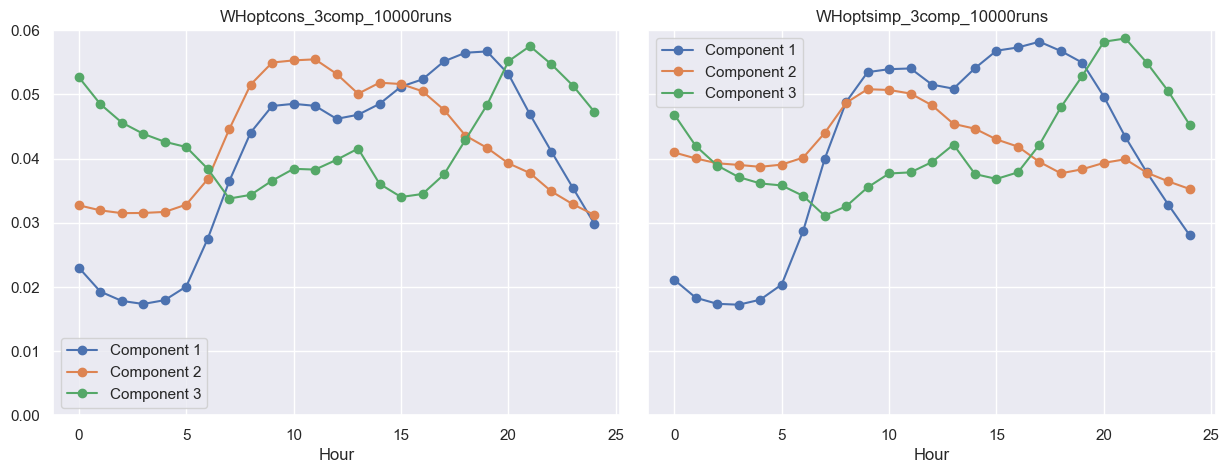

In [20]:
fig, axs = plot_components(H, figsize=(15, 5), ylim=(0, 0.06))

# Assess assumptions on the residuals

In [21]:
reconstructed = {}
residuals = {}

for method in method_names:
    if method not in nmf_method_names:
        reconstructed[method] = X_fpca[method]
    else:
        reconstructed_smooth = np.dot(W[method], H[method])
        n_eval_points = H[method].shape[1]
        reconstructed[method] = pd.DataFrame(reconstructed_smooth[:, np.arange(0, n_eval_points, int(n_eval_points / 24))], index=input_df.index)

    residuals[method] = X.values - reconstructed[method]

## Residual curves

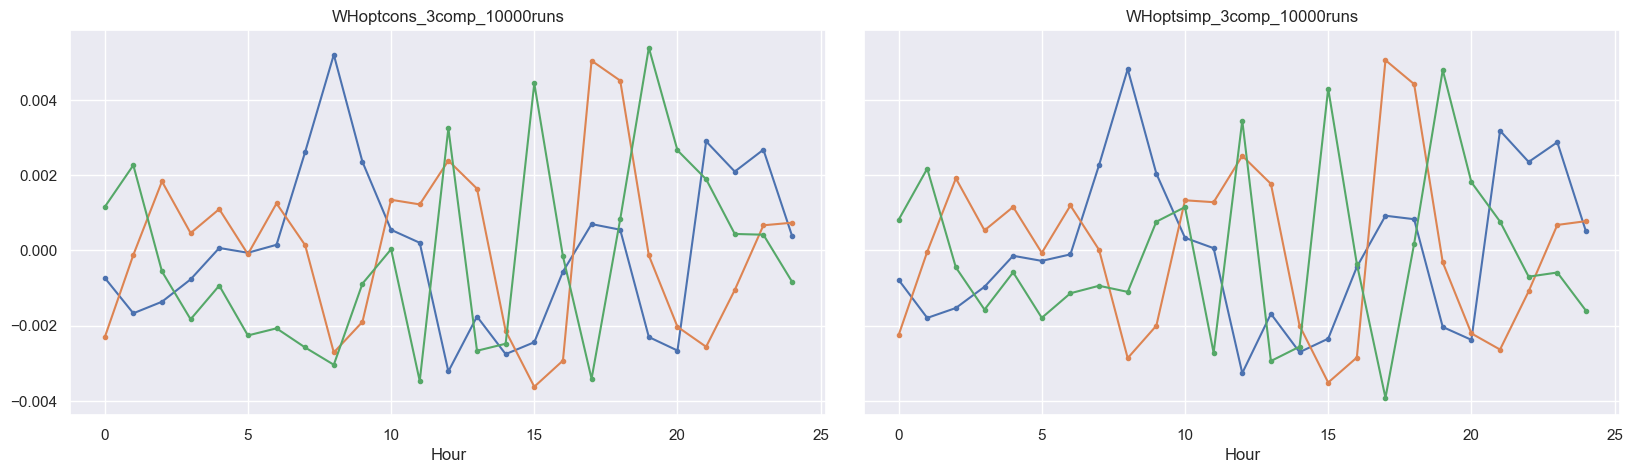

In [25]:
fig, axs = plot_residual_curves(residuals, n_curves_plotted=3, figsize=(20, 5), markersize=3)

## Residual histograms

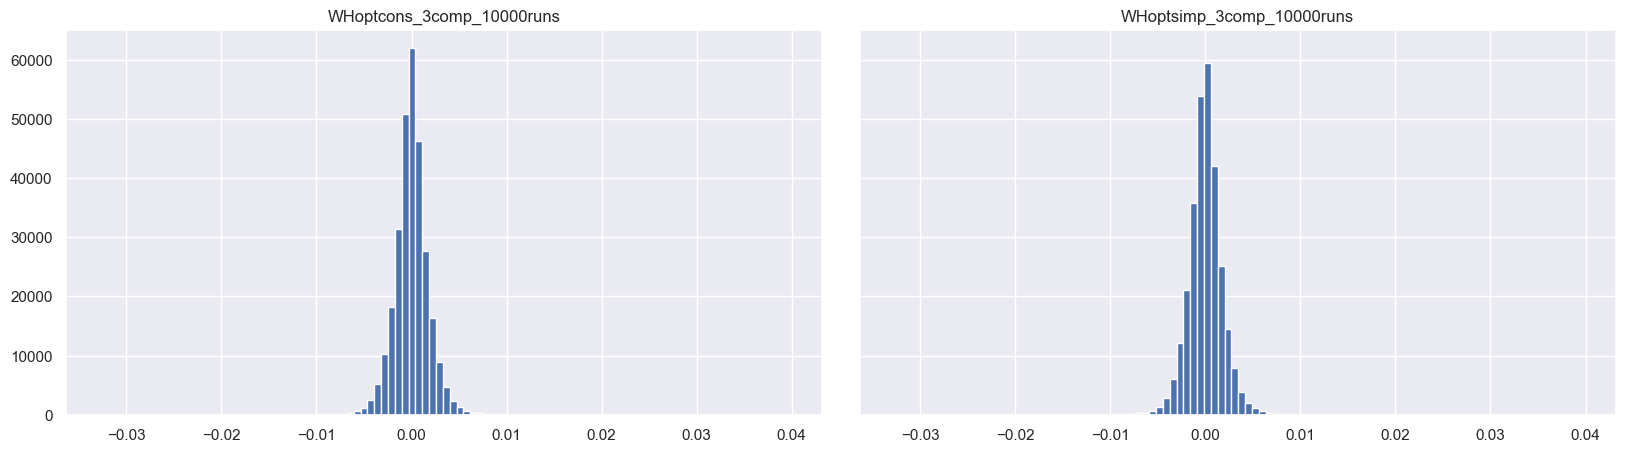

In [26]:
nrows = floor(sqrt(len(method_names)))
ncols = ceil(len(method_names) / nrows)

fig, axs = plt.subplots(nrows, ncols, figsize=(20, 5), squeeze=False, sharex=True, sharey=True)

for idx, (method, E)  in enumerate(residuals.items()):
    resid = E.values.flatten()
    i = idx // ncols
    j = idx % ncols
    axs[i, j].hist(resid, bins=100)
    axs[i, j].set_title(method)
plt.subplots_adjust(wspace=0.05)

## Homoschedasticity

In [27]:
residuals_with_info = {}

for method in method_names:
    resid_df = pd.concat([residuals[method], unit_info], axis=1)
    resid_df = resid_df.melt(id_vars=info_cols, var_name='hour', value_name='residual')
    residuals_with_info[method] = resid_df

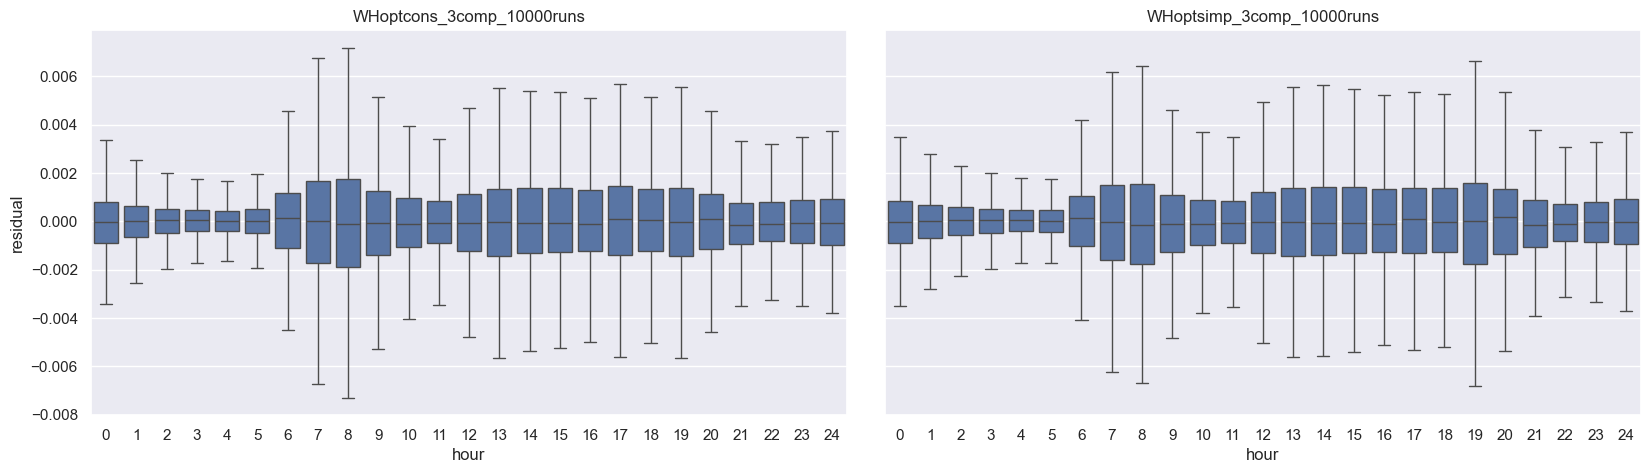

In [28]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='hour', showfliers=False, figsize=(20,5))

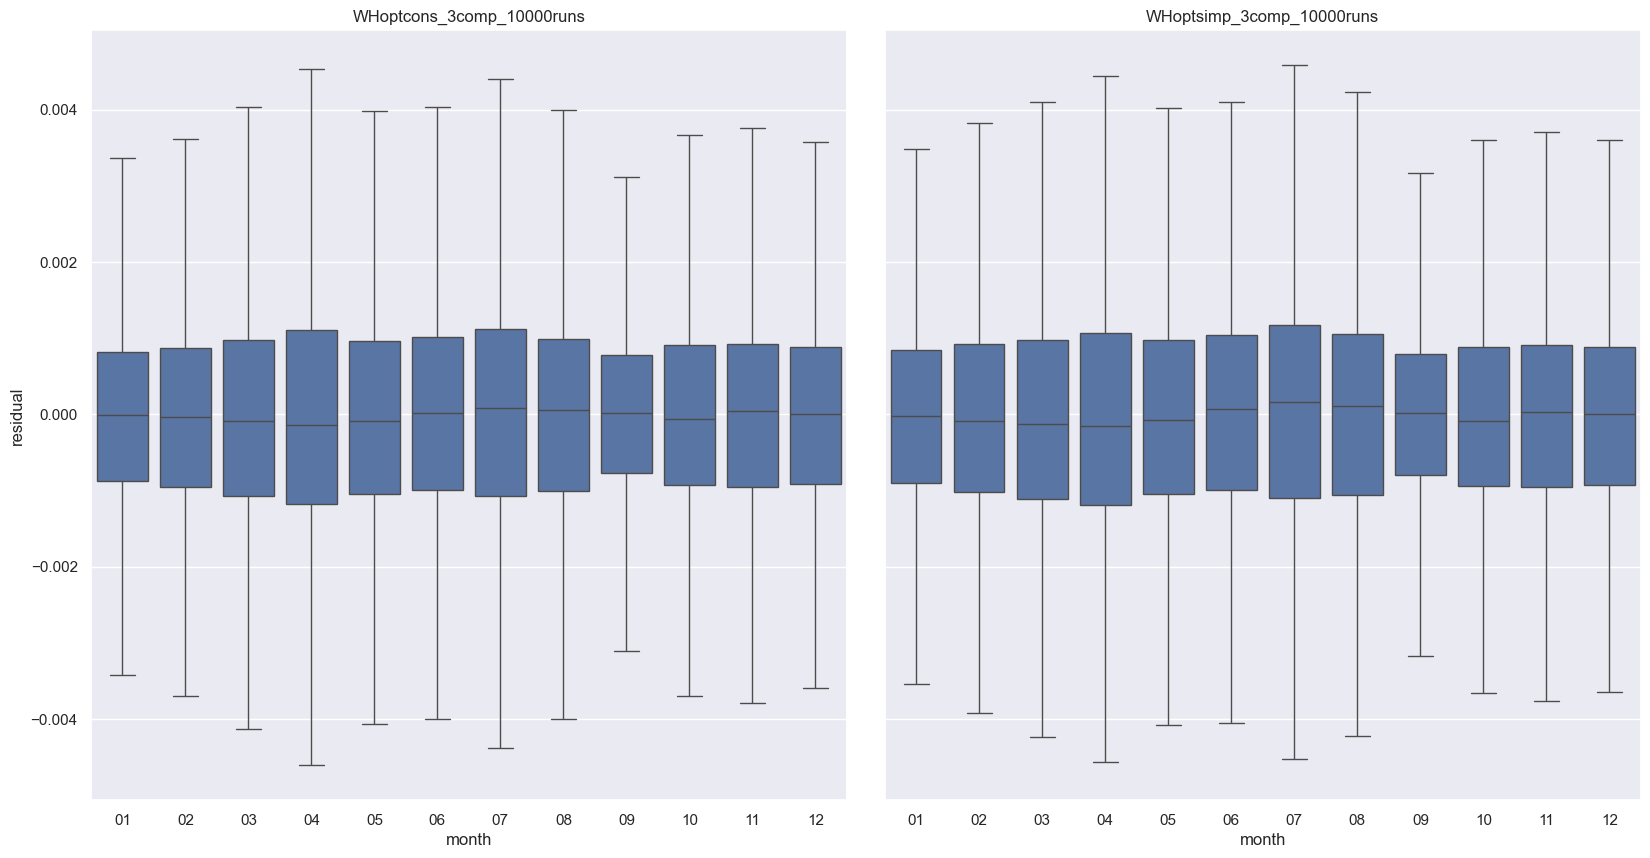

In [29]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='month', showfliers=False)

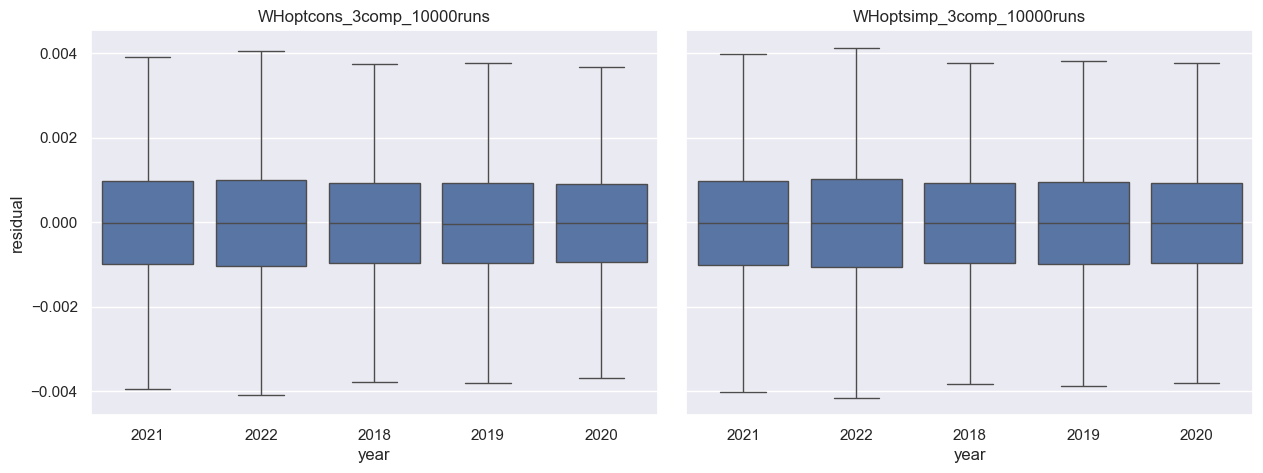

In [30]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='year', showfliers=False, figsize=(15,5))

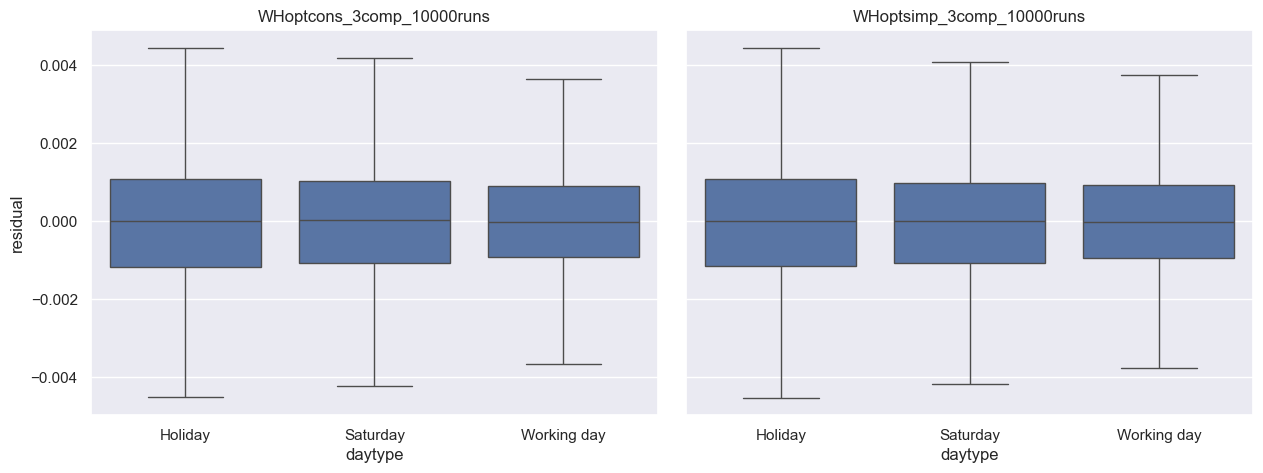

In [31]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='daytype', showfliers=False, figsize=(15,5))

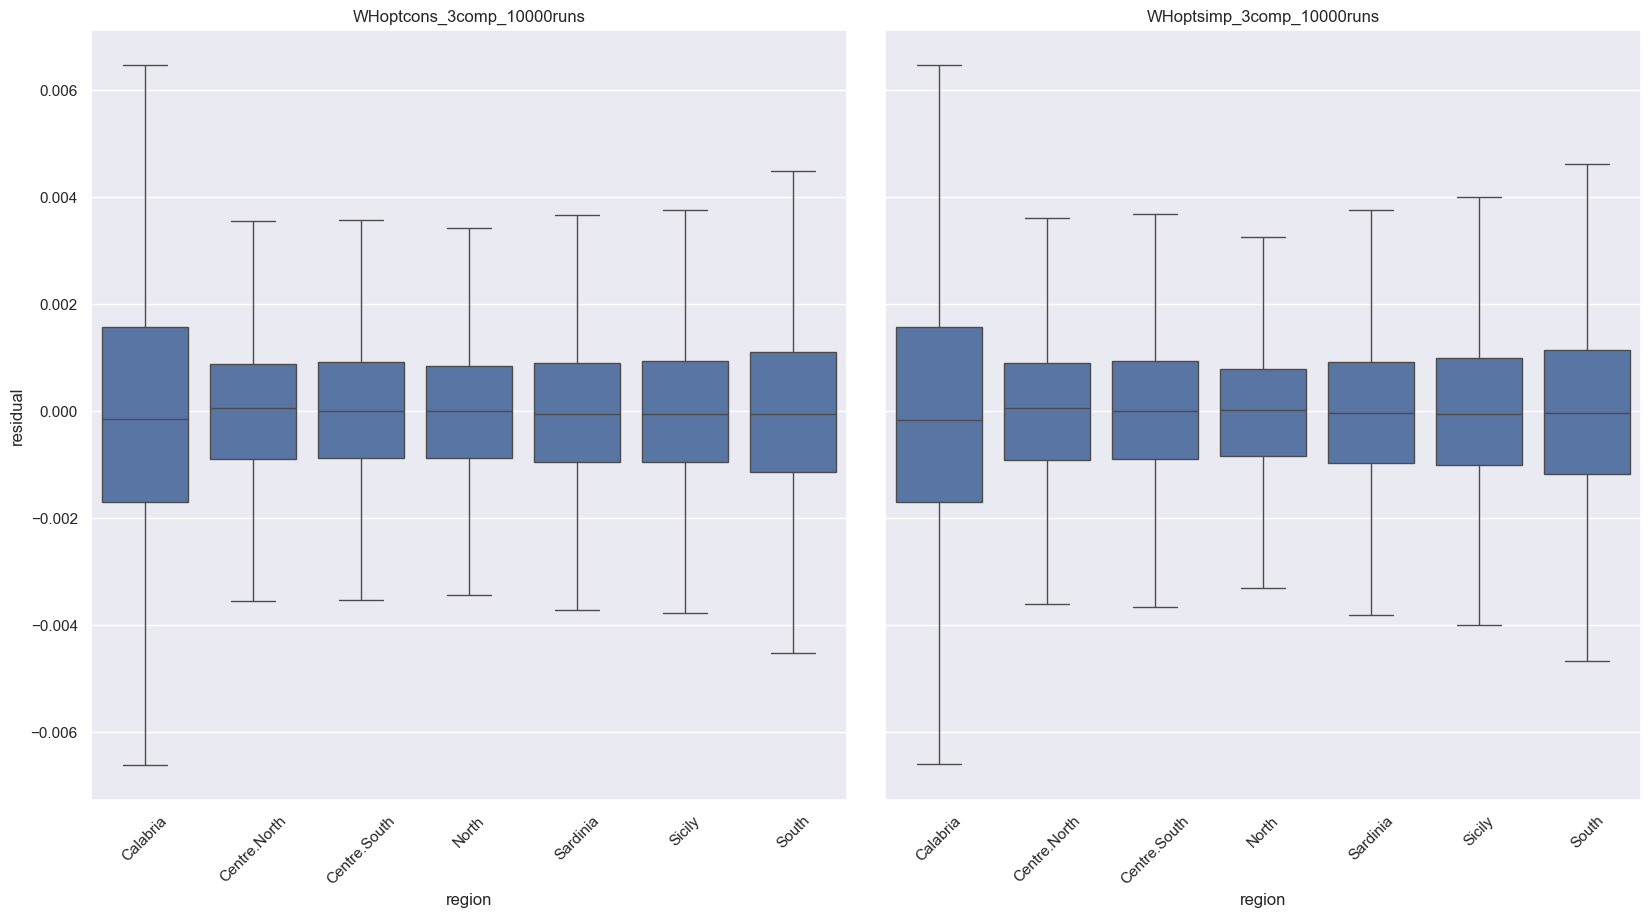

In [32]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='region', showfliers=False, rotate_xlabels=True)

# Compare model fit

In [33]:
print(method_names)

['WHoptcons_3comp_10000runs', 'WHoptsimp_3comp_10000runs']


In [35]:
# Sample data for groups
method1 = 'WHoptcons_3comp_10000runs'
method2 = 'WHoptsimp_3comp_10000runs'

# Performing Levene's test
res1 = residuals_with_info[method1]['residual']
res2 = residuals_with_info[method2]['residual']
statistic, p_value = levene(res1, res2)

# Print estimated variance
print("Sum of squared residuals for {} is {:.4f} for {:,} samples".format(method1, (res1**2).sum(), len(res1)))
print("Sum of squared residuals for {} is {:.4f} for {:,} samples".format(method2, (res2**2).sum(), len(res2)))

# Checking the result
print("\nTest Statistic:", statistic)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print(f"\nReject the null hypothesis")
else:
    print(f"\nFail to reject the null hypothesis")

Sum of squared residuals for WHoptcons_3comp_10000runs is 0.9452 for 292,150 samples
Sum of squared residuals for WHoptsimp_3comp_10000runs is 0.9440 for 292,150 samples

Test Statistic: 4.870990921163665
p-value: 0.027312200452156512

Reject the null hypothesis


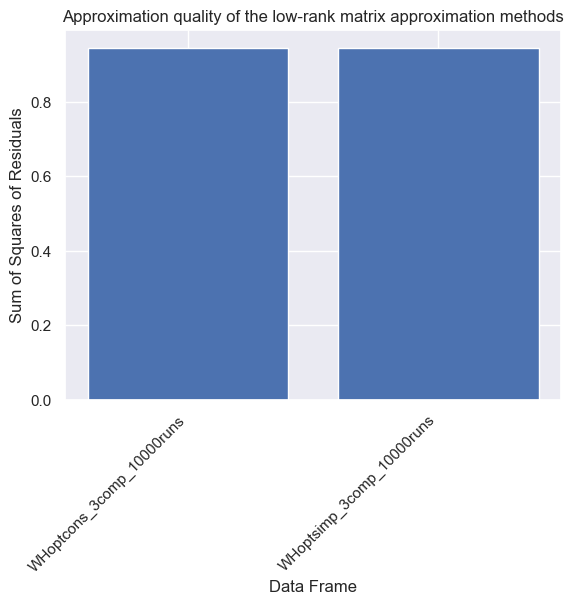

In [34]:
# Initialize lists to store data
labels = []
sums_of_squares = []

# Iterate over the dictionary of data frames
for key, res_df in residuals_with_info.items():
    # Calculate sum of squares of residuals
    sum_of_squares = (res_df['residual'] ** 2).sum()
    
    # Append to lists
    labels.append(key)
    sums_of_squares.append(sum_of_squares)

# Create bar plot
plt.bar(labels, sums_of_squares)
plt.xlabel('Data Frame')
plt.ylabel('Sum of Squares of Residuals')
plt.title('Approximation quality of the low-rank matrix approximation methods')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Showing examples of reconstructed curves

In [36]:
method_names

['WHoptcons_3comp_10000runs', 'WHoptsimp_3comp_10000runs']

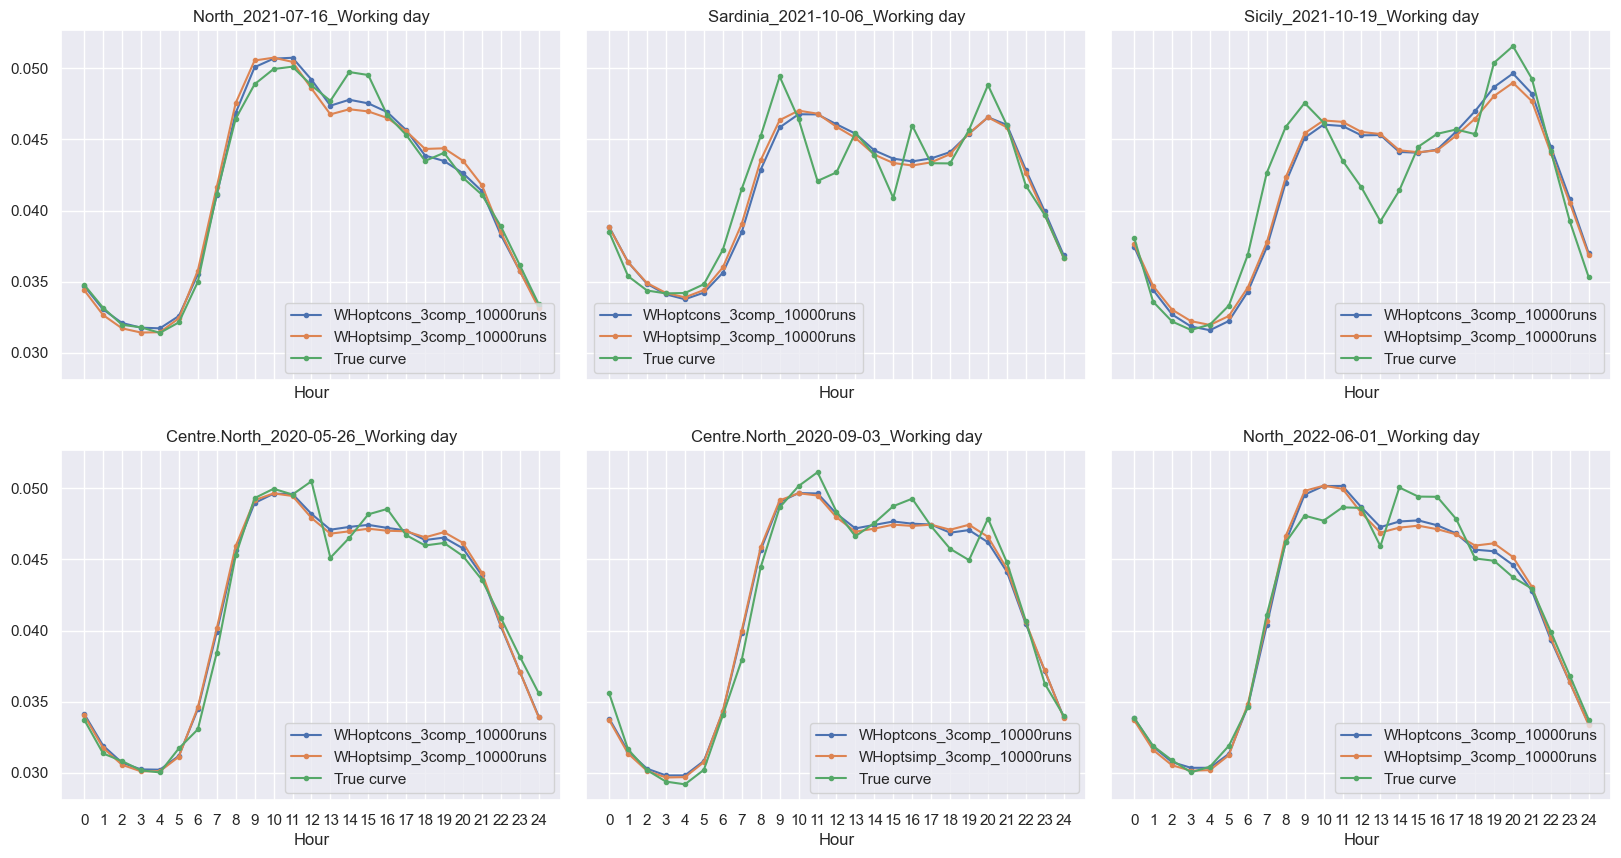

In [42]:
# override_methods = ['WHopt_3comp_smoothed_1000runs', 'WHopt_4comp_10000runs']
override_methods = None
fig, ax = plot_random_reconstructed(reconstructed, X, override_methods=override_methods, n_obs=6, figsize=(20,10), markersize=3)

# Analyse concentrations

In [43]:
W_with_info = {}
for method in nmf_method_names:
    W_df = pd.DataFrame(W[method], index=input_df.index, columns=[f"Component {k+1}" for k in range(W[method].shape[1])])
    W_df = pd.concat([W_df, unit_info], axis=1)
    W_with_info[method] = W_df.sort_values(['year', 'month', 'region'])

In [44]:
region_order = [
    'North',
    'Centre.North',
    'Sardinia',
    'Centre.South',
    'South',
    'Calabria',
    'Sicily'
]

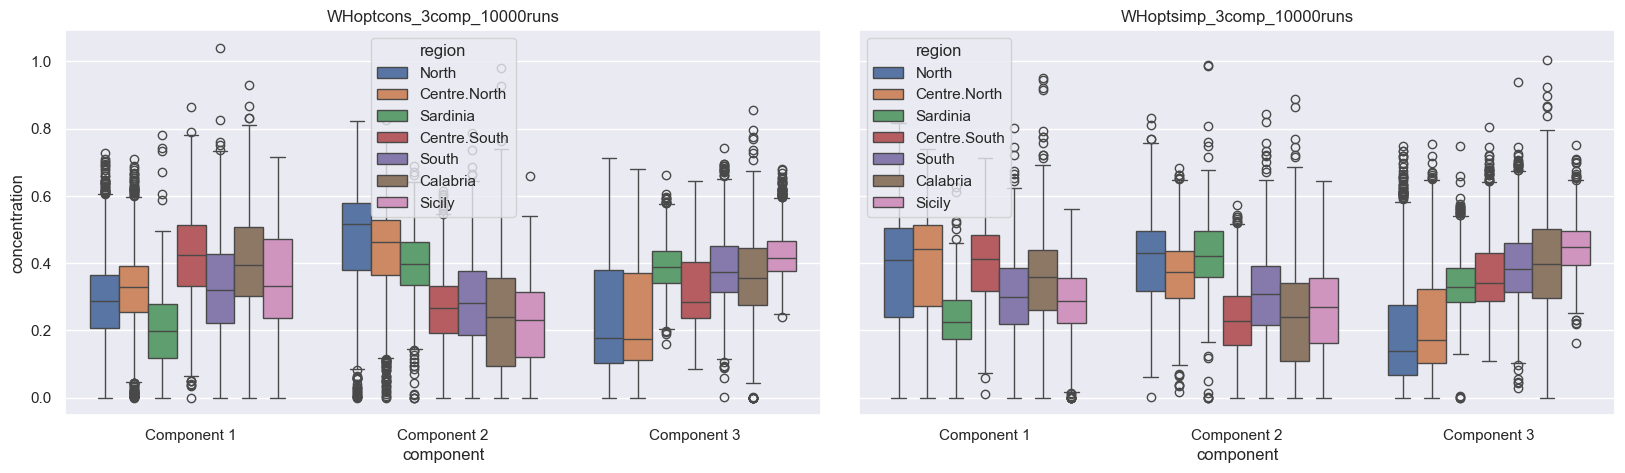

In [45]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='region', hue_order=region_order, figsize=(20,5),
                                    #    subplots_titles=['Distribution of Concentrations per Market Zone'], legend_position='upper right'
                                       )

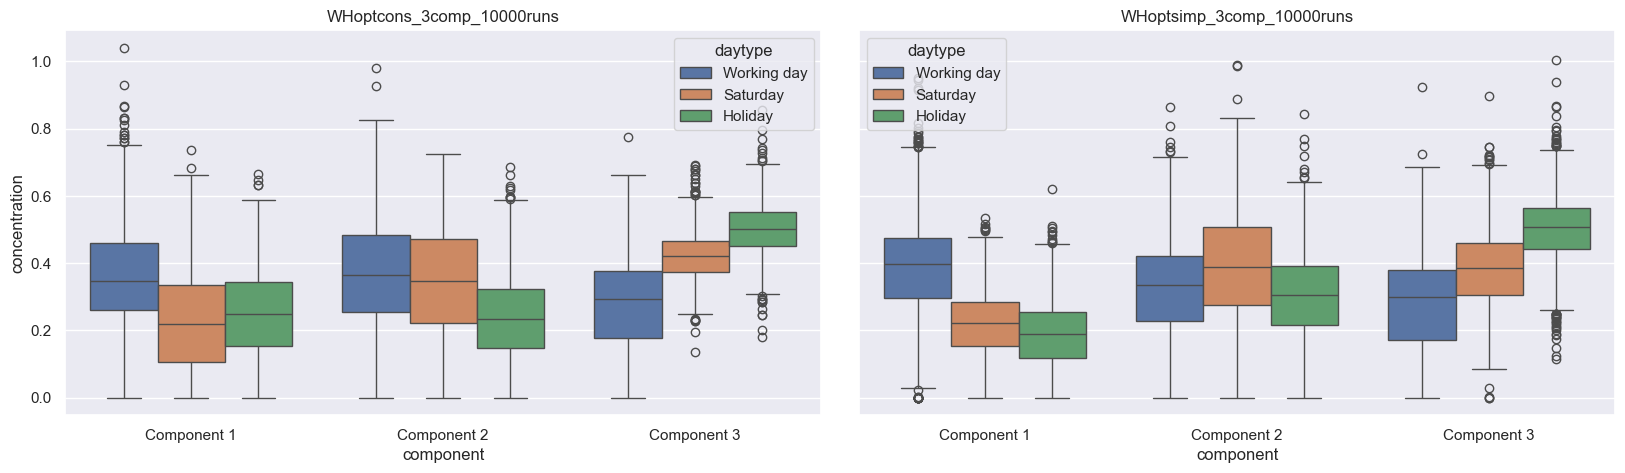

In [46]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='daytype', hue_order=['Working day', 'Saturday', 'Holiday'], figsize=(20,5),
                                    #    subplots_titles=['Distribution of Concentrations per Day Type'], legend_position='upper right'
                                       )

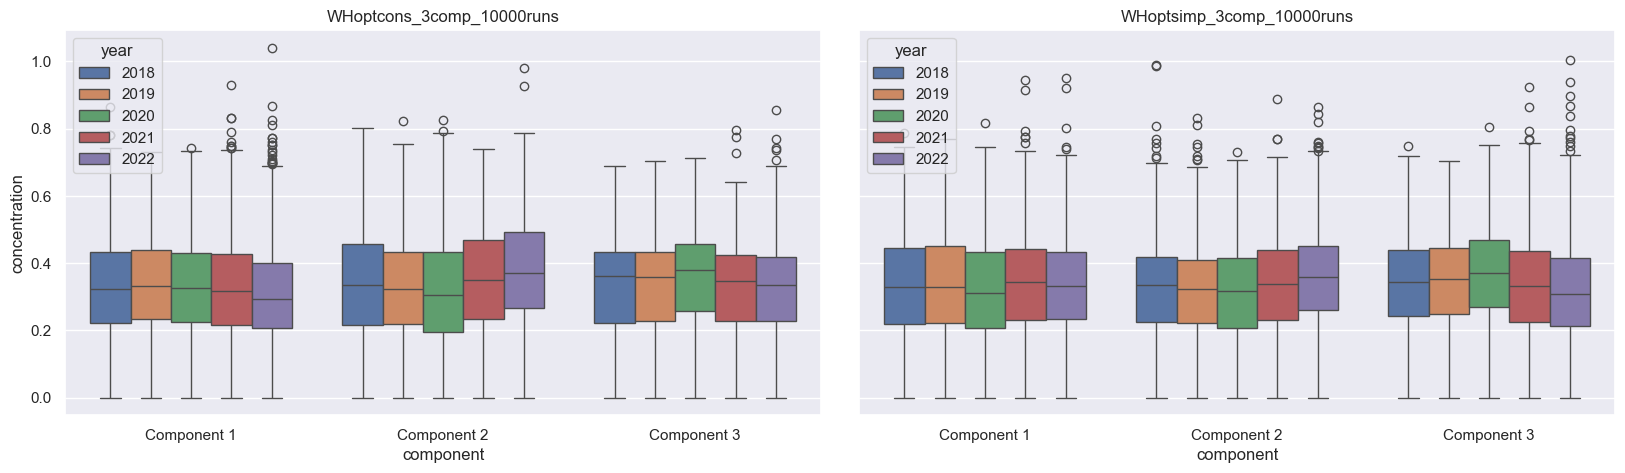

In [47]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='year', figsize=(20,5),
                                    #    subplots_titles=['Distribution of Concentrations per Year'], legend_position='upper right', ncols_legend=6
                                       )

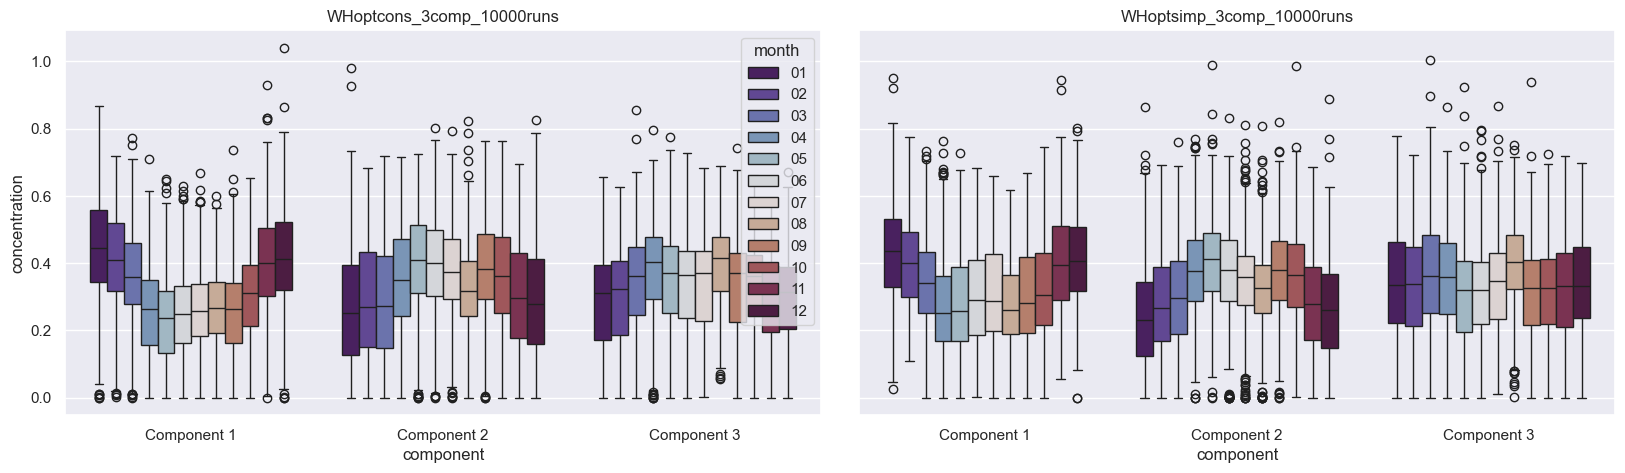

In [48]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='month', palette='twilight_shifted', replicate_legend=False, figsize=(20,5),
                                    #    subplots_titles=['Distribution of Concentrations per Month'], legend_position='upper right', ncols_legend=6
                                       )

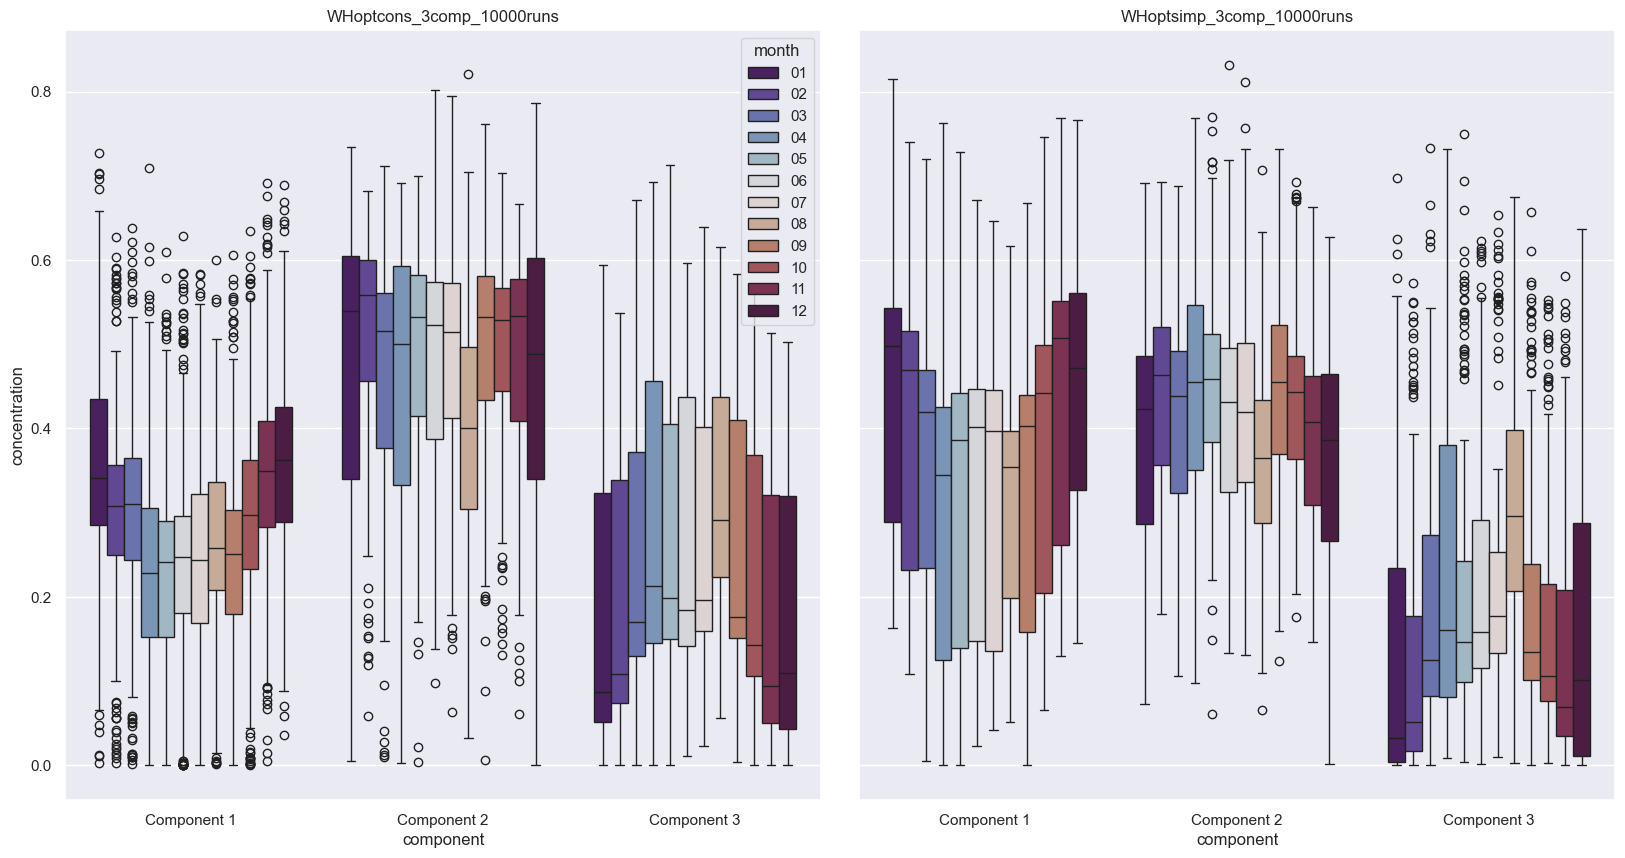

In [49]:
plot_dict = {key: df[df.region == 'North'] for key, df in W_with_info.items()}
fig, ax = plot_concentrations_boxplots(plot_dict, x='component', hue='month', palette='twilight_shifted', replicate_legend=False)